In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from ord2011 import ORD2011
from ord2017 import ORD2017

In [2]:
'''
O'Hara-Rudy 2011
O'Hara CiPA v1.0 2017
'''
model_version = 2011

cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
current_li = ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']

protocol = vc_protocols.hERG_CiPA()
# protocol = pickle.load(open("./trial_steps_ramps_Kernik_200_50_4_-120_60_paper/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl", 'rb'))
# protocol = pickle.load(open("./trial_steps_ramps_ORD2011_288_51_4_-121_61/shortened_trial_steps_ramps_ORD2011_288_51_4_-121_61_500_artefact_False_short.pkl", 'rb'))

end_time = protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 10000)
print(end_time)

3900


In [3]:
start_time = time.time()

import simulator_myokit
'''
Simulation with Myokit
'''
model_path = None
if model_version==2011:
    model_path = "../mmt-model-files/ord-2011_VC.mmt" 
elif model_version==2017:
    model_path = "../mmt-model-files/ohara-cipa-v1-2017_VC.mmt" 
    
model_myokit, protocol_myokit, script = myokit.load(model_path)
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-8, vhold=-80.0) # 1e-12, 1e-14 # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.0001
sim_myokit.name = "ORD2011"
params = {         
    'cell.mode': cell_types['Mid-myocardial'],    
}
sim_myokit.set_simulation_params(params)
y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=None, extra_log=['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL', 'ik1.IK1', 'inal.INaL'])

sol_myokit = {}
times_myokit = d_myokit['engine.time']
sol_myokit["Voltage"] = [protocol.get_voltage_at_time(t) for t in times_myokit]
sol_myokit["I_Na"] = d_myokit['ina.INa']
sol_myokit["I_Kr"] = d_myokit['ikr.IKr']
sol_myokit["I_Ks"] = d_myokit['iks.IKs']
sol_myokit["I_To"] = d_myokit['ito.Ito']
sol_myokit["I_CaL"] =d_myokit['ical.ICaL']
sol_myokit["I_K1"] = d_myokit['ik1.IK1']
sol_myokit["I_NaL"] = d_myokit['inal.INaL']
   
print("--- %s seconds ---"%(time.time()-start_time))

--- 3.242731809616089 seconds ---


In [4]:
import simulator_scipy
'''
Simulation with Scipy
'''
model_scipy = None
if model_version==2011:
    model_scipy = ORD2011(protocol)
elif model_version==2017:
    model_scipy = ORD2017(protocol)

sim_scipy = simulator_scipy.Simulator(model_scipy)

start_time = time.time()

sim_scipy.model.change_cell(cell_types['Mid-myocardial'])
# model_scipy.y0[1:] = y0_myokit
y0 = sim_scipy.pre_simulate( pre_step=5000, protocol='constant', v0=-80 )   
d_scipy = sim_scipy.simulate(t_span=t_span, t_eval=None, method='BDF', max_step=1.0, atol=1e-8, rtol=1e-8) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.001
# sol_scipy = sim_scipy.simulate2( t_eval, max_step=1e-5*100000, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1E-3*self.time_conversion,  atol=1E-2, rtol=1E-4

sol_scipy = {}
times_scipy = d_scipy.t
sol_scipy["Voltage"] = [protocol.get_voltage_at_time(t) for t in times_scipy]
sol_scipy["I_Na"] = sim_scipy.model.current_response_info.get_current(['I_Na'])
sol_scipy["I_Kr"] = sim_scipy.model.current_response_info.get_current(['I_Kr'])
sol_scipy["I_Ks"] = sim_scipy.model.current_response_info.get_current(['I_Ks'])
sol_scipy["I_To"] = sim_scipy.model.current_response_info.get_current(['I_To'])
sol_scipy["I_CaL"] = sim_scipy.model.current_response_info.get_current(['I_CaL'])
sol_scipy["I_K1"] = sim_scipy.model.current_response_info.get_current(['I_K1'])
sol_scipy["I_NaL"] = sim_scipy.model.current_response_info.get_current(['I_NaL'])

print("--- %s seconds ---"%(time.time()-start_time))

--- 6.183344602584839 seconds ---


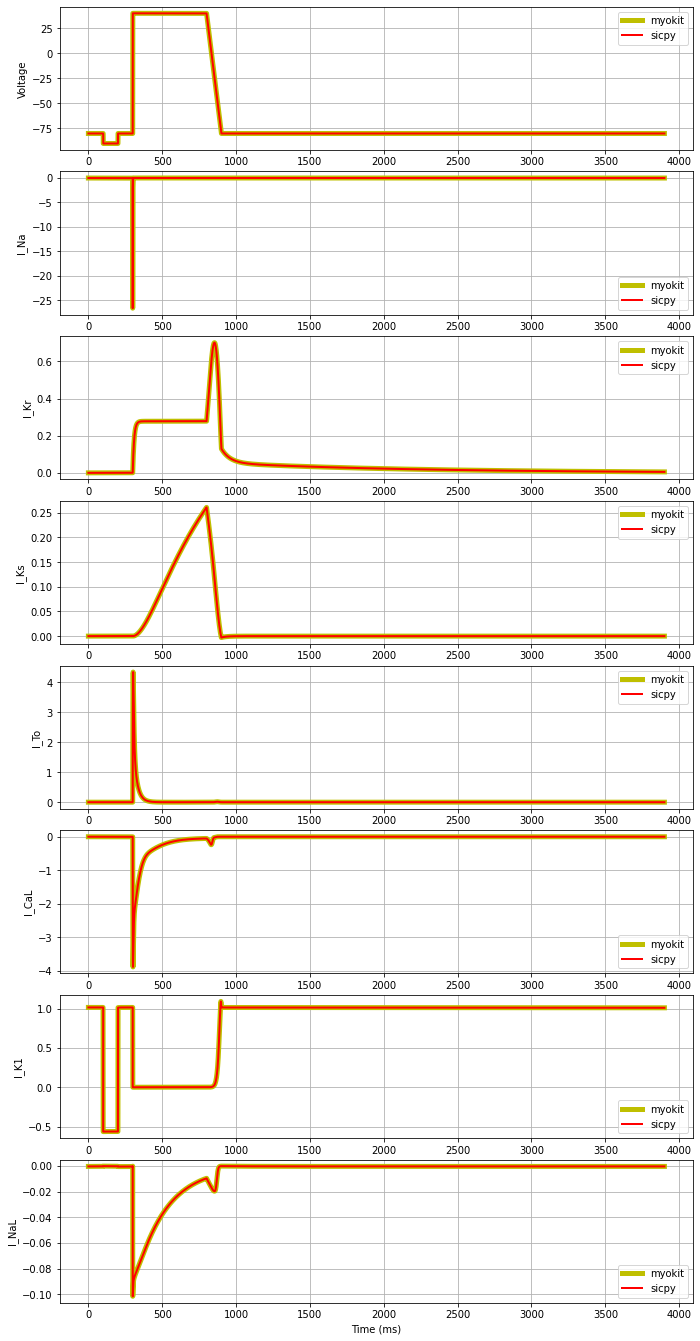

In [5]:
'''
Plot
'''
fig, ax = plt.subplots(8,1, figsize=(10,20))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol_myokit.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times_myokit, values, label='myokit', color='y', linewidth=5)     
    ax[i].plot( times_scipy, sol_scipy[name], label='sicpy', color='r', linewidth=2)   
    ax[i].legend()
    ax[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "ORd2011_VC"), dpi=100)

In [6]:
print("Complete")

Complete
